In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


data = pd.read_csv('051622 Sample 1.txt', delimiter='\t', header=None)
pv = data[1].to_numpy()
T = data[0][1] - data[0][0]
timestamp = np.arange(start = 0, stop = len(pv)*T, step = T)

array([0.00000e+00, 1.00000e-04, 2.00000e-04, ..., 6.45997e+01,
       6.45998e+01, 6.45999e+01])

(0.0, 0.16)

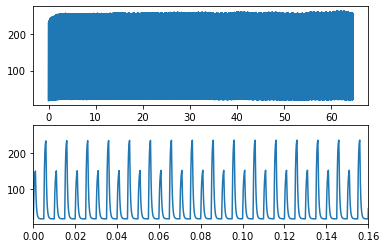

In [15]:
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.plot(timestamp,pv)
ax2.plot(timestamp,pv)
ax2.set_xlim(0, 1600*T)

array([233.7344, 234.1563, 234.2656, ..., 258.1406, 258.0156, 258.0938])

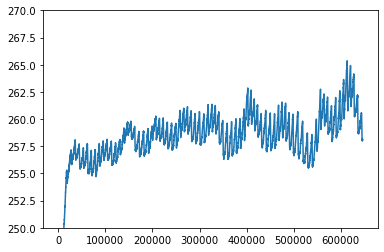

In [81]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
import numpy as np

peaks, _ = find_peaks(pv, height=200)
nir = pv[peaks]
plt.plot(peaks, nir)
plt.ylim(250, 270)

#store high peak values
a = np.array(nir)
high_peak = a[np.logical_and(a >= 220, a <= 270)]
high_peak



array([150.1406, 150.7969, 150.8906, ..., 161.5781, 161.7344, 161.7031])

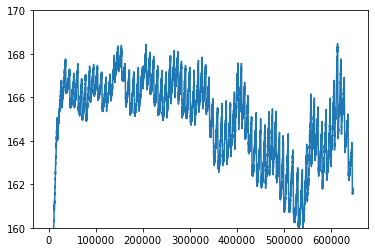

In [82]:

peaks, _ = find_peaks(pv, height=(150,200))
nir = pv[peaks]
plt.plot(peaks, nir)
plt.ylim(160, 170)

#store low peak values
a = np.array(nir)
low_peak = a[np.logical_and(a >= 140, a <= 170)]
low_peak



/var/folders/l7/h3nhqt8n2rl5hxy9gsqrk58r0000gn/T/ipykernel_1222/1998701187.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


<AxesSubplot:>

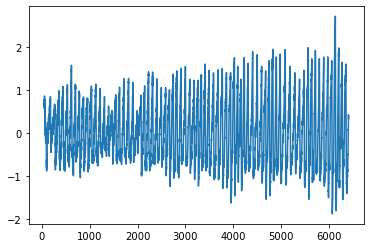

In [107]:
from matplotlib import pyplot
from pandas import read_csv
from pandas import datetime
import pandas as pd
from scipy import signal

# detrend the low_peak series
data_dict = {'x': peaks,
             'y': low_peak}

data = pd.DataFrame(data_dict)
data.to_csv("lowpeak.csv")
series = pd.read_csv('lowpeak.csv')
#decompose series
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_series = seasonal_decompose(series['y'], model='additive',period=100)
#remove trend and seasonal components
series_adjusted = series.y - decompose_series.seasonal- decompose_series.trend
series_adjusted.plot()



In [ ]:
def basic_filter(data, mode='rolling', window=262, threshold=3):

    data : pandas.Series
        The time series to filter.
    mode : str, optional, default: 'rolling'
        Whether to filter in rolling or expanding basis.
    window : int, optional, default: 262
        The number of periods to compute the mean and standard
        deviation.
    threshold : int, optional, default: 3
        The number of standard deviations above the mean.
        
    Returns
    -------
    series :
    }
    msg = f"Type must be of pandas.Series but {type(data)} was passed."
    assert isinstance(data, pd.Series), msg
    
    series = data.copy()
    
    # rolling/expanding objects
    pd_object = getattr(series, mode)(window=window)
    mean = pd_object.mean()
    std = pd_object.std()
    
    upper_bound = mean + threshold * std
    lower_bound = mean - threshold * std
    
    outliers = ~series.between(lower_bound, upper_bound)
    # fill false positives with 0
    outliers.iloc[:window] = np.zeros(shape=window)
    
    series = series.to_frame()
    series['outliers'] = np.array(outliers.astype('int').values)
    series.columns = ['Close', 'Outliers']
    
    return series

/var/folders/l7/h3nhqt8n2rl5hxy9gsqrk58r0000gn/T/ipykernel_1222/3990891437.py:8: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  series = read_csv('lowpeak.csv', header=0,index_col=0, squeeze=True)


<AxesSubplot:>

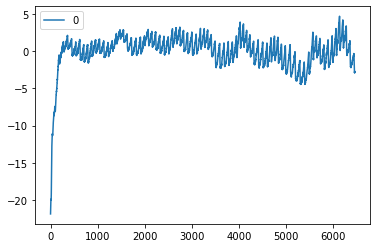

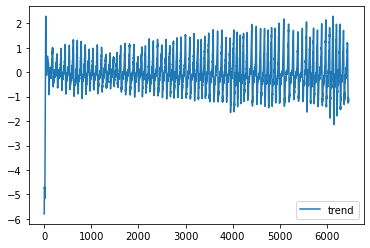

In [26]:

# detrend the high_peak series
data_dict = {'x': peaks,
             'y': high_peak
}
data_dict
data = pd.DataFrame(data_dict)
data.to_csv("lowpeak.csv")
series = read_csv('lowpeak.csv', header=0,index_col=0, squeeze=True)

#remove linear trend
detrended = signal.detrend(series.y)
detrended_df = pd.DataFrame(detrended)
detrended_df.plot()

#remove seasonal trend
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(series.y, model='additive', extrapolate_trend='freq',period=int(len(series.y)/100))
detrended = series.y.values - res.trend

detrended_df = pd.DataFrame(detrended)
detrended_df.plot()


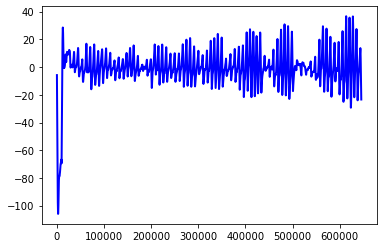

In [28]:

from scipy.signal import lfilter
n = 100  # the larger n is, the smoother curve will be
b = [100 / n] * n
a = 1
y = lfilter(b,a,detrended)
plt.plot(series.x, y, linewidth=2, linestyle="-", c="b") 